<a href="https://colab.research.google.com/github/oliia/BootcampDatathons/blob/main/Datathon1_travel_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dphi.tech/practice/challenge/49#data

# Imports

In [91]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, make_scorer

from sklearn.pipeline import Pipeline

# Helpers

In [92]:
def plot_data(X, y): 
	plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15) 
	plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r') 
	plt.legend() 
	return plt.show()

In [93]:
# Test data - encoding categorical columns 
# Remove additional columns 
def remove_add_col(df_test_processed, cat_columns, cat_dummies) :
  
  '''
  df_test_processed dataframe with new data, encoded  
  cat_columns list of the name of categorical columns 
  cat_dummies list of all encoded columns, one for each encoding, after processing train dataframe
  ''' 
  
  for col in df_test_processed.columns:
      if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
          print("Removing additional feature {}".format(col))
          df_test_processed.drop(col, axis=1, inplace=True)
      
  return df_test_processed

In [94]:
# Test data - encoding categorical columns
# Adds missing columns 

def add_missing_columns(df_test_processed, cat_dummies, processed_columns):


  for col in cat_dummies:
    if col not in df_test_processed.columns:
        print("Adding missing feature {}".format(col))
        df_test_processed[col] = 0
   
  # reorder columns 
  df_test_processed = df_test_processed[processed_columns]

  return df_test_processed

# Training data and EDA

In [95]:
insurance_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" )

In [96]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [97]:
insurance_data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


In [98]:
insurance_data.groupby('Agency')['Claim'].value_counts()

Agency  Claim
ADM     0           56
ART     0          247
        1            1
C2B     0         5865
        1          415
CBH     0           70
CCR     0          152
        1            3
CSR     0           65
        1            1
CWT     0         6506
        1           66
EPX     0        26557
        1          155
JWT     0          576
        1            4
JZI     0         4826
        1           25
KML     0          287
        1            6
LWC     0          508
        1           24
RAB     0          577
SSI     0          803
        1            4
TST     0          388
        1            1
TTW     0           69
        1            3
Name: Claim, dtype: int64

# Missing data

In [99]:
def dropping_cols(data_test):
  
  ''' 
  '''

  data_test.drop(columns = ['Commision (in value)', 'Gender'], inplace = True)

  return data_test

## Numerical

In [100]:
# numerical
insurance_data[insurance_data['Duration']==0].count()

Agency                  49
Agency Type             49
Distribution Channel    49
Product Name            49
Duration                49
Destination             49
Net Sales               49
Commision (in value)    49
Gender                  33
Age                     49
Claim                   49
dtype: int64

In [101]:
((insurance_data['Commision (in value)'] == 1) | (insurance_data['Commision (in value)'] == 0)).value_counts()

True     26784
False    21476
Name: Commision (in value), dtype: int64

In [102]:
insurance_data.drop(columns = 'Commision (in value)', inplace = True)

## Categorical

In [103]:
# categorical 
# Null values in Gender column
insurance_data['Gender'].value_counts()

M    7137
F    6762
Name: Gender, dtype: int64

In [104]:
# Gender has >20% of missing values, and doesn't seem to be a strong predictor. Thus I drop the column.
insurance_data.drop(columns = 'Gender', inplace = True)

In [105]:
# Is my dataset balanced?
insurance_data['Claim'].value_counts()
# see solution later

0    47552
1      708
Name: Claim, dtype: int64

In [106]:
insurance_data.describe()

,Duration,Net Sales,Age,Claim
count,48260.000000,48260.000000,48260.000000,48260.000000
mean,49.546602,40.747647,39.927269,0.014671
std,104.828147,48.823217,14.027329,0.120231
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,35.000000,0.000000
50%,22.000000,27.000000,36.000000,0.000000
75%,53.000000,48.000000,43.000000,0.000000
max,4881.000000,666.000000,118.000000,1.000000


# Preprocessing pipeline 

In [107]:
# Creating data 
y = insurance_data['Claim']
X = insurance_data.drop(columns = 'Claim', inplace = False)

In [108]:
X.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Age
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,29
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,36
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,25
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,24
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,23


## Categorical data

In [109]:
cat = X.select_dtypes(['object']).columns

In [110]:
X.select_dtypes(['object']).columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination'],
      dtype='object')

In [111]:
# Get the categorical columns
cat_columns = X.select_dtypes(['object']).columns

In [112]:
# Encode categorical data 
X_enc = pd.get_dummies(X, drop_first = True, prefix_sep="__", columns=cat_columns)

In [113]:
X_enc.head()

,Duration,Net Sales,Age,Agency__ART,Agency__C2B,Agency__CBH,Agency__CCR,Agency__CSR,Agency__CWT,Agency__EPX,Agency__JWT,Agency__JZI,Agency__KML,Agency__LWC,Agency__RAB,Agency__SSI,Agency__TST,Agency__TTW,Agency Type__Travel Agency,Distribution Channel__Online,Product Name__2 way Comprehensive Plan,Product Name__24 Protect,Product Name__Annual Gold Plan,Product Name__Annual Silver Plan,Product Name__Annual Travel Protect Gold,Product Name__Annual Travel Protect Platinum,Product Name__Annual Travel Protect Silver,Product Name__Basic Plan,Product Name__Bronze Plan,Product Name__Cancellation Plan,Product Name__Child Comprehensive Plan,Product Name__Comprehensive Plan,Product Name__Gold Plan,Product Name__Individual Comprehensive Plan,Product Name__Premier Plan,Product Name__Rental Vehicle Excess Insurance,Product Name__Silver Plan,Product Name__Single Trip Travel Protect Gold,Product Name__Single Trip Travel Protect Platinum,Product Name__Single Trip Travel Protect Silver,...,Destination__PORTUGAL,Destination__PUERTO RICO,Destination__QATAR,Destination__REPUBLIC OF MONTENEGRO,Destination__REUNION,Destination__ROMANIA,Destination__RUSSIAN FEDERATION,Destination__SAMOA,Destination__SAUDI ARABIA,Destination__SERBIA,Destination__SEYCHELLES,Destination__SINGAPORE,Destination__SLOVENIA,Destination__SOLOMON ISLANDS,Destination__SOUTH AFRICA,Destination__SPAIN,Destination__SRI LANKA,Destination__SWEDEN,Destination__SWITZERLAND,"Destination__TAIWAN, PROVINCE OF CHINA","Destination__TANZANIA, UNITED REPUBLIC OF",Destination__THAILAND,Destination__TIBET,Destination__TRINIDAD AND TOBAGO,Destination__TUNISIA,Destination__TURKEY,Destination__TURKMENISTAN,Destination__UGANDA,Destination__UKRAINE,Destination__UNITED ARAB EMIRATES,Destination__UNITED KINGDOM,Destination__UNITED STATES,Destination__URUGUAY,Destination__UZBEKISTAN,Destination__VANUATU,Destination__VENEZUELA,Destination__VIET NAM,"Destination__VIRGIN ISLANDS, U.S.",Destination__ZAMBIA,Destination__ZIMBABWE
0,61,19.8,29,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,93,63.0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22,22.0,25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,14,54.5,24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,90,10.0,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [114]:
# save the dummy columns 
cat_dummies = [col for col in X_enc 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

In [115]:
cat_dummies

['Agency__ART',
 'Agency__C2B',
 'Agency__CBH',
 'Agency__CCR',
 'Agency__CSR',
 'Agency__CWT',
 'Agency__EPX',
 'Agency__JWT',
 'Agency__JZI',
 'Agency__KML',
 'Agency__LWC',
 'Agency__RAB',
 'Agency__SSI',
 'Agency__TST',
 'Agency__TTW',
 'Agency Type__Travel Agency',
 'Distribution Channel__Online',
 'Product Name__2 way Comprehensive Plan',
 'Product Name__24 Protect',
 'Product Name__Annual Gold Plan',
 'Product Name__Annual Silver Plan',
 'Product Name__Annual Travel Protect Gold',
 'Product Name__Annual Travel Protect Platinum',
 'Product Name__Annual Travel Protect Silver',
 'Product Name__Basic Plan',
 'Product Name__Bronze Plan',
 'Product Name__Cancellation Plan',
 'Product Name__Child Comprehensive Plan',
 'Product Name__Comprehensive Plan',
 'Product Name__Gold Plan',
 'Product Name__Individual Comprehensive Plan',
 'Product Name__Premier Plan',
 'Product Name__Rental Vehicle Excess Insurance',
 'Product Name__Silver Plan',
 'Product Name__Single Trip Travel Protect Gold',

In [116]:
processed_columns = list(X_enc.columns[:])

In [117]:
processed_columns

['Duration',
 'Net Sales',
 'Age',
 'Agency__ART',
 'Agency__C2B',
 'Agency__CBH',
 'Agency__CCR',
 'Agency__CSR',
 'Agency__CWT',
 'Agency__EPX',
 'Agency__JWT',
 'Agency__JZI',
 'Agency__KML',
 'Agency__LWC',
 'Agency__RAB',
 'Agency__SSI',
 'Agency__TST',
 'Agency__TTW',
 'Agency Type__Travel Agency',
 'Distribution Channel__Online',
 'Product Name__2 way Comprehensive Plan',
 'Product Name__24 Protect',
 'Product Name__Annual Gold Plan',
 'Product Name__Annual Silver Plan',
 'Product Name__Annual Travel Protect Gold',
 'Product Name__Annual Travel Protect Platinum',
 'Product Name__Annual Travel Protect Silver',
 'Product Name__Basic Plan',
 'Product Name__Bronze Plan',
 'Product Name__Cancellation Plan',
 'Product Name__Child Comprehensive Plan',
 'Product Name__Comprehensive Plan',
 'Product Name__Gold Plan',
 'Product Name__Individual Comprehensive Plan',
 'Product Name__Premier Plan',
 'Product Name__Rental Vehicle Excess Insurance',
 'Product Name__Silver Plan',
 'Product Name

## Numerical data # pas besoin de scaler avec random forests



In [118]:
# get numeric data
num_d = X.select_dtypes(exclude=['object'])

In [119]:
print(num_d)

       Duration  Net Sales  Age
0            61       19.8   29
1            93       63.0   36
2            22       22.0   25
3            14       54.5   24
4            90       10.0   23
...         ...        ...  ...
48255        39       44.0   36
48256        20       60.0   30
48257        19       29.7   43
48258         7       20.0   61
48259        35       20.0   29

[48260 rows x 3 columns]


In [120]:
'''
sc = StandardScaler()
# X_enc[num_d.columns] = sc.fit_transform(num_d) # ['Duration', 'Net Sales', 'Commision (in value)']
X_scaled = sc.fit_transform(X_enc)
'''

"\nsc = StandardScaler()\n# X_enc[num_d.columns] = sc.fit_transform(num_d) # ['Duration', 'Net Sales', 'Commision (in value)']\nX_scaled = sc.fit_transform(X_enc)\n"

# Split the data

In [121]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.3, random_state = 42)

In [122]:
X_train.shape

(33782, 185)

In [123]:
y_train.shape

(33782,)

# Tackle Imbalanced class problem

## SMOT method

In [124]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [125]:
method =  SMOTE(kind='regular')
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


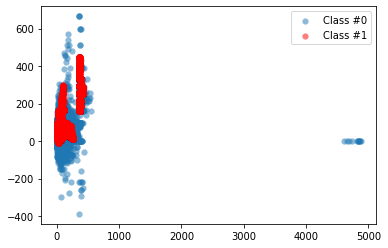

In [126]:
plot_data(X_resampled, y_resampled)

# Random Forest

In [127]:
rf = RandomForestClassifier()

## First a global randomized search CV

In [128]:
from sklearn.model_selection import RandomizedSearchCV
import pprint

In [129]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [132]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 2, 
                               verbose=2, 
                               random_state=42,
                               n_jobs = -1)

In [133]:
# Fit the random search model
rf_random.fit(X_resampled, y_resampled)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 24.5min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [134]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [135]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Then a more precise GridSearchCV 

In [137]:
from sklearn.model_selection import GridSearchCV

In [143]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [70, 80],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [144]:
grid_search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 33.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [151]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [147]:
best_model = grid_search.best_estimator_

In [148]:
y_pred = best_model.predict(X_test)

In [149]:
f1_score(y_test,y_pred)

0.10584958217270195

# Test Submission 

In [152]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv')

In [153]:
test_data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


In [154]:
# preprocess test_data
test_data.drop(columns = ['Gender', 'Commision (in value)'  ], inplace = True)

In [155]:
#test_enc = pd.get_dummies(test_data, drop_first = True)
test_enc = pd.get_dummies(test_data, prefix_sep="__", 
                                   columns=cat_columns, drop_first = True)

In [156]:
test_enc.head()

,Duration,Net Sales,Age,Agency__ART,Agency__C2B,Agency__CBH,Agency__CCR,Agency__CSR,Agency__CWT,Agency__EPX,Agency__JWT,Agency__JZI,Agency__KML,Agency__LWC,Agency__RAB,Agency__SSI,Agency__TST,Agency__TTW,Agency Type__Travel Agency,Distribution Channel__Online,Product Name__2 way Comprehensive Plan,Product Name__24 Protect,Product Name__Annual Gold Plan,Product Name__Annual Silver Plan,Product Name__Annual Travel Protect Gold,Product Name__Annual Travel Protect Platinum,Product Name__Annual Travel Protect Silver,Product Name__Basic Plan,Product Name__Bronze Plan,Product Name__Cancellation Plan,Product Name__Child Comprehensive Plan,Product Name__Comprehensive Plan,Product Name__Gold Plan,Product Name__Individual Comprehensive Plan,Product Name__Premier Plan,Product Name__Rental Vehicle Excess Insurance,Product Name__Silver Plan,Product Name__Single Trip Travel Protect Gold,Product Name__Single Trip Travel Protect Platinum,Product Name__Single Trip Travel Protect Silver,...,Destination__OMAN,Destination__PAKISTAN,Destination__PANAMA,Destination__PAPUA NEW GUINEA,Destination__PERU,Destination__PHILIPPINES,Destination__POLAND,Destination__PORTUGAL,Destination__QATAR,Destination__ROMANIA,Destination__RUSSIAN FEDERATION,Destination__RWANDA,Destination__SAUDI ARABIA,Destination__SENEGAL,Destination__SIERRA LEONE,Destination__SINGAPORE,Destination__SLOVENIA,Destination__SOUTH AFRICA,Destination__SPAIN,Destination__SRI LANKA,Destination__SWEDEN,Destination__SWITZERLAND,"Destination__TAIWAN, PROVINCE OF CHINA",Destination__TAJIKISTAN,"Destination__TANZANIA, UNITED REPUBLIC OF",Destination__THAILAND,Destination__TRINIDAD AND TOBAGO,Destination__TUNISIA,Destination__TURKEY,Destination__TURKS AND CAICOS ISLANDS,Destination__UGANDA,Destination__UKRAINE,Destination__UNITED ARAB EMIRATES,Destination__UNITED KINGDOM,Destination__UNITED STATES,Destination__UZBEKISTAN,Destination__VANUATU,Destination__VIET NAM,Destination__ZAMBIA,Destination__ZIMBABWE
0,24,27.0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,51,45.0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,52,21.0,21,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,89,11.0,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,10.0,33,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [157]:
test_ready = add_missing_columns(test_enc, cat_dummies= cat_dummies, processed_columns= processed_columns )

Adding missing feature Product Name__Travel Cruise Protect Family
Adding missing feature Destination__ANGOLA
Adding missing feature Destination__ARGENTINA
Adding missing feature Destination__ARMENIA
Adding missing feature Destination__BARBADOS
Adding missing feature Destination__BENIN
Adding missing feature Destination__BHUTAN
Adding missing feature Destination__BOSNIA AND HERZEGOVINA
Adding missing feature Destination__BOTSWANA
Adding missing feature Destination__CAYMAN ISLANDS
Adding missing feature Destination__CHILE
Adding missing feature Destination__DOMINICAN REPUBLIC
Adding missing feature Destination__FRENCH POLYNESIA
Adding missing feature Destination__GUADELOUPE
Adding missing feature Destination__GUATEMALA
Adding missing feature Destination__GUINEA-BISSAU
Adding missing feature Destination__KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF
Adding missing feature Destination__KYRGYZSTAN
Adding missing feature Destination__LIBYAN ARAB JAMAHIRIYA
Adding missing feature Destination__MALI
A

In [ ]:
# test_scaled = sc.fit_transform(test_ready)

In [160]:
# predict 
test_pred = best_model.predict(test_ready)

In [ ]:
#predict with cv 
#test_pred_cv = logreg_cv.predict(test_ready)

In [161]:
prediction = pd.DataFrame(test_pred)


In [162]:
prediction.rename(columns = {0:'prediction'}, inplace = True)

In [163]:
prediction

,prediction
0,0
1,0
2,0
3,0
4,0
...,...
15827,0
15828,0
15829,0
15830,0


In [164]:
prediction.to_csv('prediction2.csv', index = False)

In [ ]:
#75	olgab	8.34765529094034 #linreg

In [ ]:
#99	olgab	9.574468085106384 #randomforest